In [1]:
## Environment and packages
using Pkg; Pkg.activate("../../."); 
# Pkg.instantiate()

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


In [2]:
using HDF5
using JLD
using LinearAlgebra
using Statistics
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio
using Plots; gr()

Plots.GRBackend()

In [3]:
#nx, ny = 100, 100 # Size of the grid This are defined later 

# these in should be 50m, but we are using 1 in MWE_iceflow.jl
Δx, Δy = 50, 50 # meters 
Δt = 1.0/12.0 # timestep in years
t = 0
t₁ = 3

# Numerical method parameters
tolnl = 1e-2 # 1e-4  # this ensures that we are going to run always itMax iterations, independenly of the error
itMax = 60
damp = 0.85
dτsc   = 1.0/2.0
ϵ     = 1e-4            # small number
#nout = 25                # error check frequency
cfl  = max(Δx^2,Δy^2)/4.1
#D_max = 200000 # maximum value of expected diffusivity

# Glacier parameters 
#A₀ = 1
#ρ = 900 # wrong units? Should it be 900 kg/m^3?
#g = 9.81
#n = 3

609.7560975609757

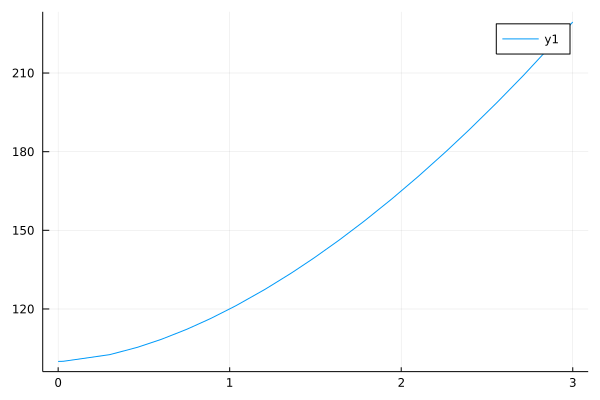

In [50]:
fakeD(t) = 100*(1 + .2*t^1.7)
plot(fakeD, 0, t₁)

In [51]:
D_max = 1.5 * fakeD(t₁)
println("Dmax: ", D_max)

Dmax: 344.19023519771343


In [52]:
@views avg(A) = 0.25 * ( A[1:end-1,1:end-1] .+ A[2:end,1:end-1] .+ A[1:end-1,2:end] .+ A[2:end,2:end] )
@views avg_x(A) = 0.5 .* ( A[1:end-1,:] .+ A[2:end,:] )
@views avg_y(A) = 0.5 .* ( A[:,1:end-1] .+ A[:,2:end] )

avg_y (generic function with 1 method)

In [209]:
function heatflow!(T,t,t₁,iterMax=500)

    println("Running forward PDE heat flow model...\n")
    
    let             
    total_iter = 0
    ts_i = 1

    while t < t₁
            
        let
        iter = 1
        err = 10e10
        Hold = copy(T) 
        dTdt = zeros(nx, ny) 

        D = fakeD(t)

        while iter < iterMax+1

            Err = copy(T)

            F, dτ = Heat(T, D)

            # implicit method with Tullio  
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]

            T_ = copy(T)
            @tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ)# [pad(i-1,1,1),pad(j-1,1,1)]) 


            # Error assertion
            Err = Err .- T
            err = maximum(Err)
                  
            if isnan(err)
                error("""NaNs encountered.  Try a combination of:
                            decreasing `damp` and/or `dtausc`, more smoothing steps""")
            elseif err>10e8
                error("""Inestability detected""")
            elseif iter == itMax && err > tolnl
                error("""Desired convergence tolerance don't reached. Increase the number of iterations
                            itMax or decrease the tolerance tolnl. Current error after $iter iterations is $err""")            
            end

            iter += 1
            total_iter += 1
                                        
        end

        t += Δt

        end

    end 

    end

    return T
end

heatflow! (generic function with 2 methods)

In [204]:
function Heat(T, D)
   
    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D_max))))

    return F, dτ
 
end

Heat (generic function with 1 method)

### Generate reference dataset

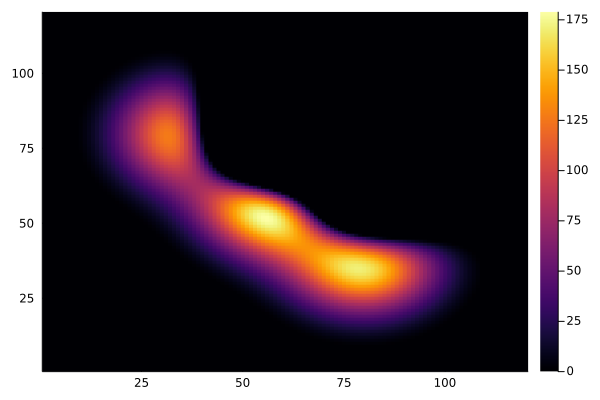

In [205]:
function truncated_gaussian(i₀, j₀, off) 
    
    M = [ 250 * exp( - ( (i - i₀)^2 + (j - j₀)^2 ) / 300 ) - off for i in 1:nx, j in 1:ny ]
    max.(0., M)
    
end

nx, ny = 120, 120

#T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

#T₀ = [ -(i - nx/2)^2 - (j - ny/.6)^2 + 40000 for i in 1:nx, j in 1:ny ]
#T₀ = max.(0., T₀)

T₀ = 1.5 * truncated_gaussian(nx/2, ny/2, 0) + 
     1 * truncated_gaussian(nx/3, ny/1.5, 0) +
     1 * truncated_gaussian(nx/1.5, ny/3, 0) - 
     4 * truncated_gaussian(nx/1.5, ny/2, 0) - 
     2 * truncated_gaussian(nx/2, ny/1.5, 0)

T₀ = max.(0., T₀ .- 10)

heatmap(T₀, clim=(0, maximum(T₀)))

In [206]:
T₀

120×120 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [210]:
reference = "simulate"
#reference = "load"

if reference == "simulate"
    # Make simulation for reference training matrix and store it
    T_ref = heatflow!(T₀,t,t₁)
elseif reference == "load"
    # Load stored T ref matrix for training
    T_ref = load(joinpath(root_dir, "data/H_ref.jld"))["T"]
end

Running forward PDE heat flow model...



120×120 Matrix{Float64}:
 0.0  0.0           0.0           …  0.0           0.0           0.0
 0.0  2.48324e-109  6.38311e-107     4.71055e-47   0.0           0.0
 0.0  6.34987e-107  3.45318e-105     5.45529e-45   4.29282e-47   0.0
 0.0  3.22318e-105  2.95167e-104     0.0           4.94433e-45   0.0
 0.0  9.22956e-105  0.0              0.0           0.0           0.0
 0.0  0.0           0.0           …  2.56392e-40   0.0           0.0
 0.0  0.0           0.0              3.96907e-39   1.95043e-40   0.0
 0.0  0.0           4.72154e-97      0.0           3.11312e-39   0.0
 0.0  4.12083e-97   0.0              1.99776e-36   0.0           0.0
 0.0  0.0           2.8743e-94       2.26575e-34   1.0898e-36    0.0
 0.0  2.20451e-94   1.06678e-91   …  7.07564e-34   1.43695e-34   0.0
 0.0  8.67794e-92   1.16531e-91      7.89169e-33   5.64752e-34   0.0
 0.0  2.09995e-91   0.0              1.28554e-30   3.43165e-33   0.0
 ⋮                                ⋱                              
 0.0  8.2345

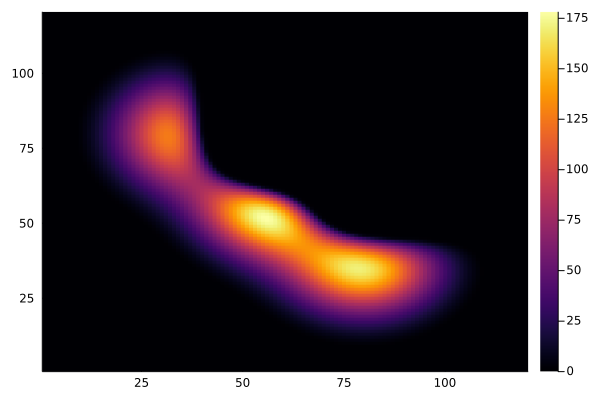

In [211]:
heatmap(T_ref, clim=(0, maximum(T_ref)))

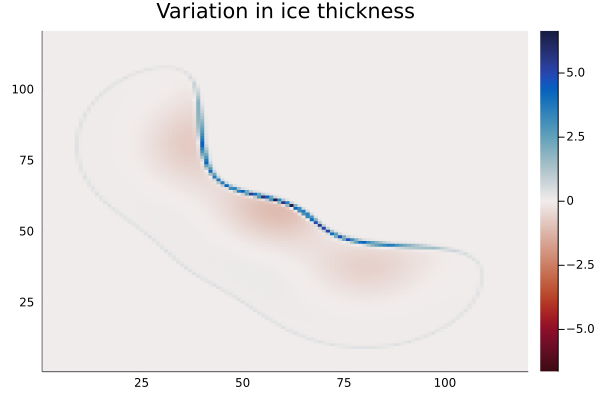

In [212]:
lim = maximum( abs.(T_ref .- T₀) )
heatmap(T_ref .- T₀, c = cgrad(:balance,rev=true),   clim = (-lim, lim), title="Variation in ice thickness")

In [213]:
lim

6.646171522249719

## Learning `D` with an UDE

In [214]:
dmin = 50
dmax = 300

#predict_D(UD, t) = (1 .+ UD(t))*100
predict_D(UD, t) = dmin .+ (dmax-dmin).*sigmoid.(UD(t))

predict_D (generic function with 1 method)

In [215]:
function heatflow!(T,UD,t,t₁)

    println("Running forward PDE heat flow model...\n")
    
    let             
    total_iter = 0
    ts_i = 1

    while t < t₁
            
        let
        iter = 1
        err = 10e10
        Hold = copy(T) 
        dTdt = zeros(nx, ny) 

        YD = predict_D(UD, [t])[1]
        #println(YD)

        while iter < itMax+1

            Err = copy(T)

            F, dτ = Heat(T, YD)

            # implicit method with Tullio  
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)]

            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]

            T_ = copy(T)
            @tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ)# [pad(i-1,1,1),pad(j-1,1,1)]) 


            # Error assertion
            Err = Err .- T
            err = maximum(Err)
                  
            if isnan(err)
                error("""NaNs encountered.  Try a combination of:
                            decreasing `damp` and/or `dtausc`, more smoothing steps""")
            elseif err>10e8
                error("""Inestability detected""")
            elseif iter == itMax && err > tolnl
                error("""Desired convergence tolerance don't reached. Increase the number of iterations
                            itMax or decrease the tolerance tolnl. Current error after $iter iterations is $err""")            
            end

            iter += 1
            total_iter += 1
                                        
        end

        t += Δt

        end

    end 

    end

    return T
end

heatflow! (generic function with 2 methods)

In [216]:
function loss(T, UD, t, t₁)
   
    T = heatflow!(T, UD, t,t₁)

    l_T = sqrt(Flux.Losses.mse(T, T_ref; agg=sum))

    # println("l_A: ", l_A)
    println("Loss in loss(): ", l_T)

    # l = l_A + l_H

    # Zygote.ignore() do    
    #     println("Values of predict_A in loss(): ", predict_A(UA, [0, 1, 2, 3, 4]'))
    #     hml = heatmap(H_ref .- H, title="Loss error")
    #     display(hml)
    # end

    return l_T
end

loss (generic function with 1 method)

In [217]:
function hybrid_train_NN!(UD, opt)
    
    T = copy(T₀)
    # println("Values of UA in hybrid_train BEFORE: ", predict_A(UA, [0, 1, 2, 3, 4]'))

    θ = Flux.params(UD)
    loss_UD, back_UD = Zygote.pullback(() -> loss(T, UD, t, t₁), θ) # with UA

    ∇_UD = back_UD(one(loss_UD)) 
    Flux.Optimise.update!(opt, θ, ∇_UD) # comment line of update of the NN to see if something is happening with the params of UA
    
    println("Loss: ", loss_UD)
    println("Gradient: ", ∇_UD)
    println("Values of predict_A in hybrid_train in hybrid_train(): ", predict_D(UD, [0, 1, 2, 3, 4]')) # Simulations here are all NaNs

    return loss_UD, ∇_UD, back_UD
    
end

hybrid_train_NN! (generic function with 1 method)

In [218]:
function train!(UD)
   
    @epochs 30 hybrid_train_NN!(UD, opt)
    
    println("Values of predict_D in train(): ", predict_D(UD, [0, 1, 2, 3, 4]'))
    
end

train! (generic function with 1 method)

We create the NN and we train the UDE

In [219]:
leakyrelu(x, a=0.01) = max(a*x, x)
relu(x) = max(0, x)
#relu2(x) = min(max(0, x), 1)

opt = RMSProp(0.002)

RMSProp(0.002, 0.9, IdDict{Any, Any}())

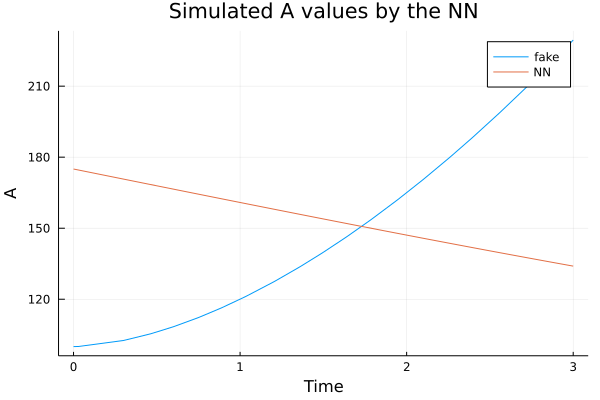

In [222]:
UD = Chain(
    Dense(1,5), 
    Dense(5,10, leakyrelu, init = Flux.glorot_normal), 
    Dense(10,5, leakyrelu, init = Flux.glorot_normal), 
    Dense(5,1) 
)

all_times = LinRange(0, t₁, 50)
# println("UD(all_times')': ",  UD_trained(all_times')')
plot(fakeD, 0, t₁, label="fake")
initial_NN = predict_D(UD, all_times')'
plot!(all_times, initial_NN, title="Simulated A values by the NN", yaxis="A", xaxis="Time", label="NN")

In [223]:
debug = "high" # low

if debug == "low"
    # Lower level debugging
    H = copy(H₀)
    θ = Flux.params(UA)
    loss_UA, back_UA = Zygote._pullback(UA -> loss(H, UA, t, t₁), UA) # with UA

    ∇_UA = back_UA(one(loss_UD)) 
    
elseif debug == "high"
    # Higher level debugging
    #loss_UD, ∇_UD, back_UD = hybrid_train_NN!(UD, opt)
    train!(UD)
end

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Running forward PDE heat flow model...

Loss in loss(): 1.739100424921127
Loss: 1.739100424921127
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.44361589129403 155.2778340915764 138.5341451820366 123.10819222786799 109.38154986585228]
Running forward PDE heat flow model...



┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.15170808791339813
Loss: 0.15170808791339813
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [172.30141253922037 151.21603577951373 132.43931352364132 115.60984670594327 101.1668970463108]
Running forward PDE heat flow model...



┌ Info: Epoch 3
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.9880881892225172
Loss: 0.9880881892225172
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.2580056806127 154.6498496627746 137.58878858014884 121.93265671790311 108.07433949076443]
Running forward PDE heat flow model...



┌ Info: Epoch 4
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.034947890438098025
Loss: 0.034947890438098025
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.92979846510212 157.03076809016375 141.19650157812146 126.45209795061342 113.14367704428795]
Running forward PDE heat flow model...



┌ Info: Epoch 5
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.6462678972252777
Loss: 0.6462678972252777
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.11082055587752 154.1243808307425 136.8066044201082 120.96786206652762 107.00948896737117]
Running forward PDE heat flow model...



┌ Info: Epoch 6
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.17290384028614245
Loss: 0.17290384028614245
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.85603597336825 156.77007641782382 140.8114305930448 125.97285544938457 112.60535455071164]
Running forward PDE heat flow model...



┌ Info: Epoch 7
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.5750433471003381
Loss: 0.5750433471003381
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.148752190638 154.26134842893498 137.02309941395063 121.24173000545281 107.31578857780599]
Running forward PDE heat flow model...



┌ Info: Epoch 8
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.1323190221004459
Loss: 0.1323190221004459
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.81045692039945 156.60884840738163 140.57393125666783 125.67793159159281 112.2748113148626]
Running forward PDE heat flow model...



┌ Info: Epoch 9
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.5312107058102085
Loss: 0.5312107058102085
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.16524411696105 154.32064617907315 137.1214283202387 121.36865103581387 107.459387261436]
Running forward PDE heat flow model...



┌ Info: Epoch 10
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.11367310413598376
Loss: 0.11367310413598376
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.77451631362314 156.4840044036967 140.3916046127885 125.45257996488519 112.02309471530519]
Running forward PDE heat flow model...



┌ Info: Epoch 11
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.4976030292990375
Loss: 0.4976030292990375
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.1700216852414 154.34361486895403 137.16176497313617 121.42185912419988 107.5202934729704]
Running forward PDE heat flow model...



┌ Info: Epoch 12
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.10608668165208521
Loss: 0.10608668165208521
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.74719905236378 156.38874525901474 140.25142003128914 125.27877490836666 111.8286971831201]
Running forward PDE heat flow model...



┌ Info: Epoch 13
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.4718694521199003
Loss: 0.4718694521199003
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.16801051139728 154.3434692285697 137.1669010477366 121.4312141924506 107.53252760884536]
Running forward PDE heat flow model...



┌ Info: Epoch 14
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.10470479391211189
Loss: 0.10470479391211189
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.72183194759026 156.3010706682727 140.12502191430482 125.1236566801943 111.65630731104056]
Running forward PDE heat flow model...



┌ Info: Epoch 15
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.4489828938437238
Loss: 0.4489828938437238
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.1609233819537 154.3279152633852 137.15039347028457 121.41460195266517 107.51656082051001]
Running forward PDE heat flow model...



┌ Info: Epoch 16
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.10662301268464552
Loss: 0.10662301268464552
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.6989078661299 156.2285346735053 140.0202413080693 124.99499000012047 111.51330876538381]
Running forward PDE heat flow model...



┌ Info: Epoch 17
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.4301379637639933
Loss: 0.4301379637639933
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.15182360488473 154.307652224638 137.1264683533828 121.38860444063221 107.49008197867315]
Running forward PDE heat flow model...



┌ Info: Epoch 18
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.1099940500143501
Loss: 0.1099940500143501
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.67886018194343 156.1661598837396 139.93087855853176 124.8857219338711 111.39221621188715]
Running forward PDE heat flow model...



┌ Info: Epoch 19
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.4144872759900141
Loss: 0.4144872759900141
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.1447892920567 154.29184443647148 137.10657143635143 121.36611649844228 107.46657024165873]
Running forward PDE heat flow model...



┌ Info: Epoch 20
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.11287634145622459
Loss: 0.11287634145622459
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.6611884631758 156.1122772823012 139.85428259194174 124.79245716126783 111.28913068395353]
Running forward PDE heat flow model...



┌ Info: Epoch 21
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.4009942734329001
Loss: 0.4009942734329001
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.13385398239893 154.26824873488005 137.0776593969374 121.33395654247528 107.43329521518305]
Running forward PDE heat flow model...



┌ Info: Epoch 22
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.11629258416696839
Loss: 0.11629258416696839
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.64407777884352 156.06369423994215 139.7857805814657 124.70940099136254 111.19758206449332]
Running forward PDE heat flow model...



┌ Info: Epoch 23
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.389360742343466
Loss: 0.389360742343466
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.12540084843948 154.2509375471436 137.05564923544193 121.30893314658239 107.40702388773099]
Running forward PDE heat flow model...



┌ Info: Epoch 24
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.119115470560848
Loss: 0.119115470560848
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.62960465059018 156.02092610533737 139.72583612066728 124.63694364307139 111.11788708815504]
Running forward PDE heat flow model...



┌ Info: Epoch 25
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.3792400437143613
Loss: 0.3792400437143613
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.11545214449404 154.2262355340779 137.0246312867763 121.273921693595 107.37045086138463]
Running forward PDE heat flow model...



┌ Info: Epoch 26
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.12322050876588789
Loss: 0.12322050876588789
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.61671808550187 155.98219733127542 139.67196001495296 124.57209423098901 111.04674015937678]
Running forward PDE heat flow model...



┌ Info: Epoch 27
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.37021019561026874
Loss: 0.37021019561026874
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.1064025108005 154.20238343549607 136.99462019639134 121.24001213392664 107.33499595412657]
Running forward PDE heat flow model...



┌ Info: Epoch 28
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.1270479655709407
Loss: 0.1270479655709407
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.60203693886461 155.9386629910067 139.6126105072214 124.50139691927527 110.96969898849929]
Running forward PDE heat flow model...



┌ Info: Epoch 29
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.3611642646939601
Loss: 0.3611642646939601
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.09697442931653 154.17872642843125 136.96503664703232 121.2067111147804 107.30026999758812]
Running forward PDE heat flow model...



┌ Info: Epoch 30
└ @ Main /Users/facundosapienza/.julia/packages/Flux/ma5BY/src/optimise/train.jl:138


Loss in loss(): 0.1305090987138205
Loss: 0.1305090987138205
Gradient: Grads(...)
Values of predict_A in hybrid_train in hybrid_train(): [173.59079525958865 155.90676244900823 139.56900900800878 124.44939899965365 110.91299659538305]
Values of predict_D in train(): [173.59079525958865 155.90676244900823 139.56900900800878 124.44939899965365 110.91299659538305]


In [230]:
for ps in Flux.params(UD)
    @show ps
    @show ∇_UD[ps]
    #println("size ps: ", size(ps))
    #println("size ∇_UA[p]: ", size(∇_UA[ps]))
    #println("type ps: ", typeof(ps))
    #println("type ∇_UA[p]: ", typeof(∇_UA[ps]))
end

ps = Float32[-0.85552627; 0.73410136; -0.3764307; 0.29179117; 0.98919004]


LoadError: KeyError: key Float32[-0.85552627; 0.73410136; … ; 0.29179117; 0.98919004] not found

We plot the results

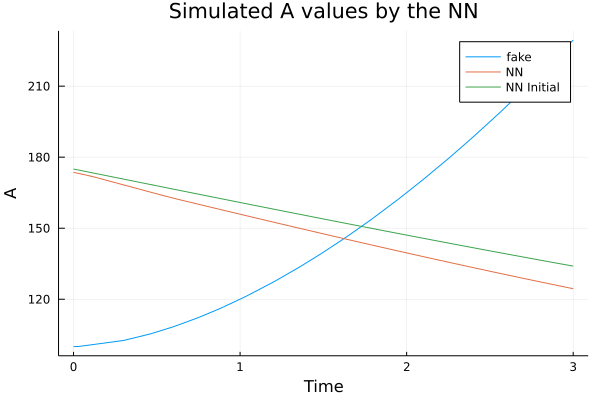

In [224]:
all_times = LinRange(0, t₁, 50)
# println("UD(all_times')': ",  UD_trained(all_times')')
plot(fakeD, 0, t₁, label="fake")
plot!(all_times, predict_D(UD, all_times')', title="Simulated A values by the NN", yaxis="A", xaxis="Time", label="NN")
plot!(all_times, initial_NN, label="NN Initial")

In [226]:
sum(fakeD.(all_times))

7414.564306201395

In [227]:
sum(predict_D(UD, all_times')')

7404.63888880811

In [228]:
sum(initial_NN)

7705.801525030358

In [ ]:
∇_UA

LoadError: UndefVarError: ∇_UA not defined